In [1]:
import sys
import json
from itertools import count
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from sklearn.datasets import make_moons
from sklearn.cluster import spectral_clustering

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

from model import LocalDictionary
from utils import *

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [2]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

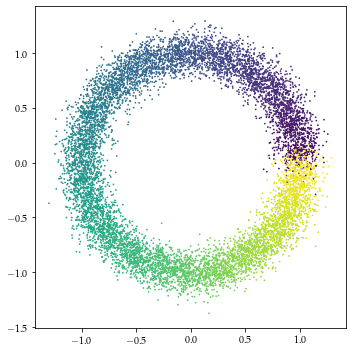

In [3]:
dataset = "circle"

y_train = F.normalize(torch.randn(10000, 2), dim=1)
y_train += 0.1 * torch.randn(y_train.shape)

theta = np.linspace(0, 2 * np.pi, 10000)
y_test = torch.tensor([np.cos(theta), np.sin(theta)]).T.float()
y_test += 0.1 * torch.randn(y_test.shape)

plt.figure(figsize=(5,5))
plt.scatter(*y_test.T, c=np.arange(y_test.shape[0]), s=0.5)
plt.tight_layout()
plt.savefig("figs/circle/input.png", dpi=300)
plt.show()

def show(path):
    net.eval()
    x_hat_test = net.encode(y_test)
    y_hat_test = net.decode(x_hat_test)
    plt.figure(figsize=(5,5))
    plt.scatter(*y_test.T, c="gray", s=0.5)
    plt.scatter(*y_hat_test.clone().detach().T, c=np.arange(y_test.shape[0]), s=5.0)
    plt.scatter(*net.W.data.T, c="red")
    if path:
        plt.tight_layout()
        plt.savefig(path, dpi=300)
    plt.show()

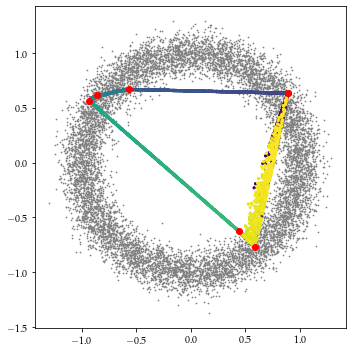

In [4]:
penalty = 1.0
net = LocalDictionary(15, 2, 7, penalty)
optimizer = optim.Adam(net.parameters())
criterion = LocalDictionaryLoss(penalty)

with torch.no_grad():
    net.W.data = y_train[torch.randperm(y_train.shape[0])][:net.hidden_size]
    net.step.fill_((net.W.data.svd()[1][0] ** -2).item())

show(f"figs/{dataset}/0.png")

 25%|██▍       | 493/2000 [00:06<00:18, 80.02it/s]

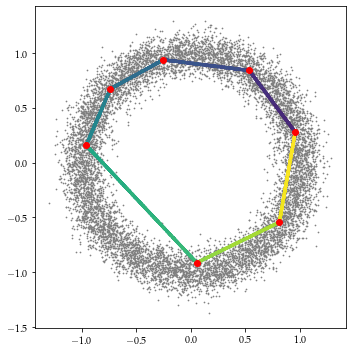

 50%|████▉     | 995/2000 [00:12<00:12, 80.82it/s]

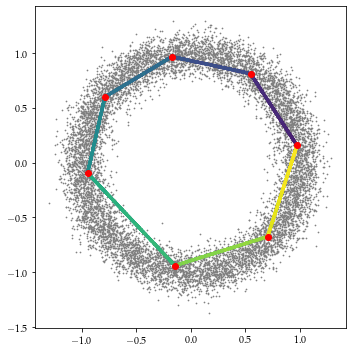

 75%|███████▍  | 1499/2000 [00:19<00:06, 82.22it/s]

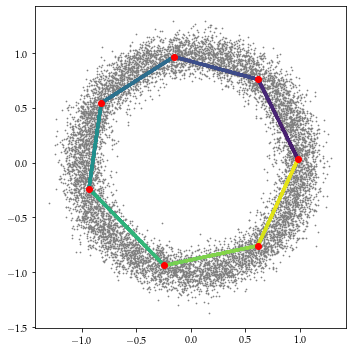

100%|█████████▉| 1994/2000 [00:26<00:00, 80.64it/s]

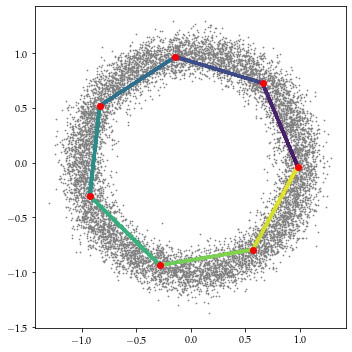

100%|██████████| 2000/2000 [00:27<00:00, 73.31it/s]


In [5]:
epochs = 2000
device = "cuda:0"
net = net.to(device)
y_train = y_train.to(device)
for epoch in tqdm(range(epochs)):
    net.train()
    optimizer.zero_grad()
    x_hat_train = net.encode(y_train)
    loss = criterion(net.W, y_train, x_hat_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) * 4 % epochs == 0:
        net = net.cpu()
        y_train = y_train.cpu()
        show(f"figs/{dataset}/{epoch+1}.png")
        net = net.to(device)
        y_train = y_train.to(device)
net = net.cpu()
y_train = y_train.cpu()

In [6]:
print("mean sparsity =", (x_hat_train.abs() > 0).float().sum(dim=1).mean().item())
print("median sparsity =", (x_hat_train.abs() > 0).float().sum(dim=1).median().item())

# sanity check
print("sum of coefficients =", x_hat_train.abs().sum(dim=1).mean().item())

mean sparsity = 1.3116999864578247
median sparsity = 1.0
sum of coefficients = 1.0
